In [1]:
from fastai.vision.all import *
from fastcore.parallel import *
import timm

In [2]:
path = Path.home()/'.fastai/data/paddy'; path

Path('/home/bilal/.fastai/data/paddy')

In [3]:
trn_path = path/'train_images'

In [4]:
files = get_image_files(trn_path); files

(#10407) [Path('/home/bilal/.fastai/data/paddy/train_images/hispa/103939.jpg'),Path('/home/bilal/.fastai/data/paddy/train_images/hispa/106442.jpg'),Path('/home/bilal/.fastai/data/paddy/train_images/hispa/105708.jpg'),Path('/home/bilal/.fastai/data/paddy/train_images/hispa/100789.jpg'),Path('/home/bilal/.fastai/data/paddy/train_images/hispa/107842.jpg'),Path('/home/bilal/.fastai/data/paddy/train_images/hispa/101076.jpg'),Path('/home/bilal/.fastai/data/paddy/train_images/hispa/109689.jpg'),Path('/home/bilal/.fastai/data/paddy/train_images/hispa/101515.jpg'),Path('/home/bilal/.fastai/data/paddy/train_images/hispa/109965.jpg'),Path('/home/bilal/.fastai/data/paddy/train_images/hispa/102479.jpg')...]

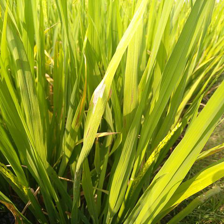

In [5]:
PILImage.create(files[0]).resize((224,224))

In [6]:
# def f(o): return PILImage.create(o).size
# %time sizes = parallel(f, files, n_workers=8)
# pd.DataFrame(list(sizes)).value_counts()

In [7]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, 
                                   item_tfms=Resize(460, method='squish'),
                                  batch_tfms=aug_transforms(size=224,min_scale=0.75))

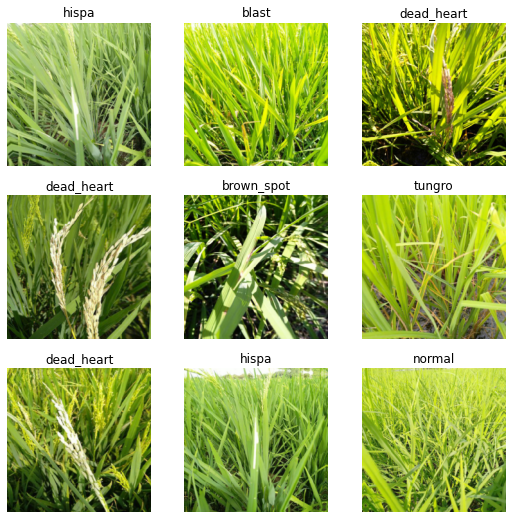

In [8]:
dls.show_batch()

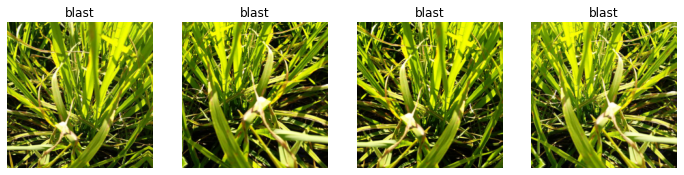

In [9]:
dls.show_batch(max_n=4, nrows=1, unique=True)

In [10]:
# timm.list_models('*convnext*')

In [11]:
learn = vision_learner(dls, 'convnext_large_in22k', metrics=error_rate).to_fp16()

SuggestedLRs(valley=0.0008317637839354575, slide=0.002511886414140463)

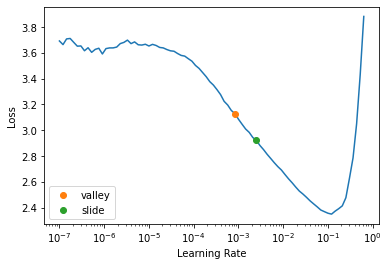

In [12]:
learn.lr_find(suggest_funcs=(valley,slide))

In [13]:
learn.fine_tune(12, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.000299,0.562017,0.170591,00:52


epoch,train_loss,valid_loss,error_rate,time
0,0.418568,0.248332,0.073042,01:10
1,0.297020,0.239245,0.069197,01:09
2,0.317350,0.258134,0.073522,01:09
3,0.224657,0.268961,0.073522,01:09
4,0.166409,0.215291,0.054781,01:09
5,0.149412,0.154958,0.041326,01:09
6,0.099182,0.170267,0.039404,01:09
7,0.077187,0.140921,0.032196,01:09
8,0.055345,0.109764,0.024507,01:09
9,0.038839,0.105785,0.025949,01:09


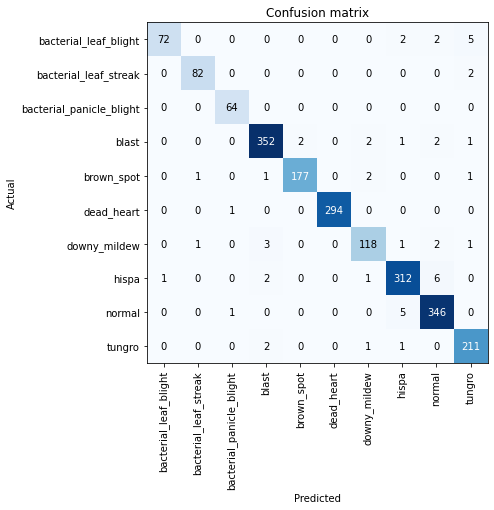

In [14]:
interp=ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(7,7))

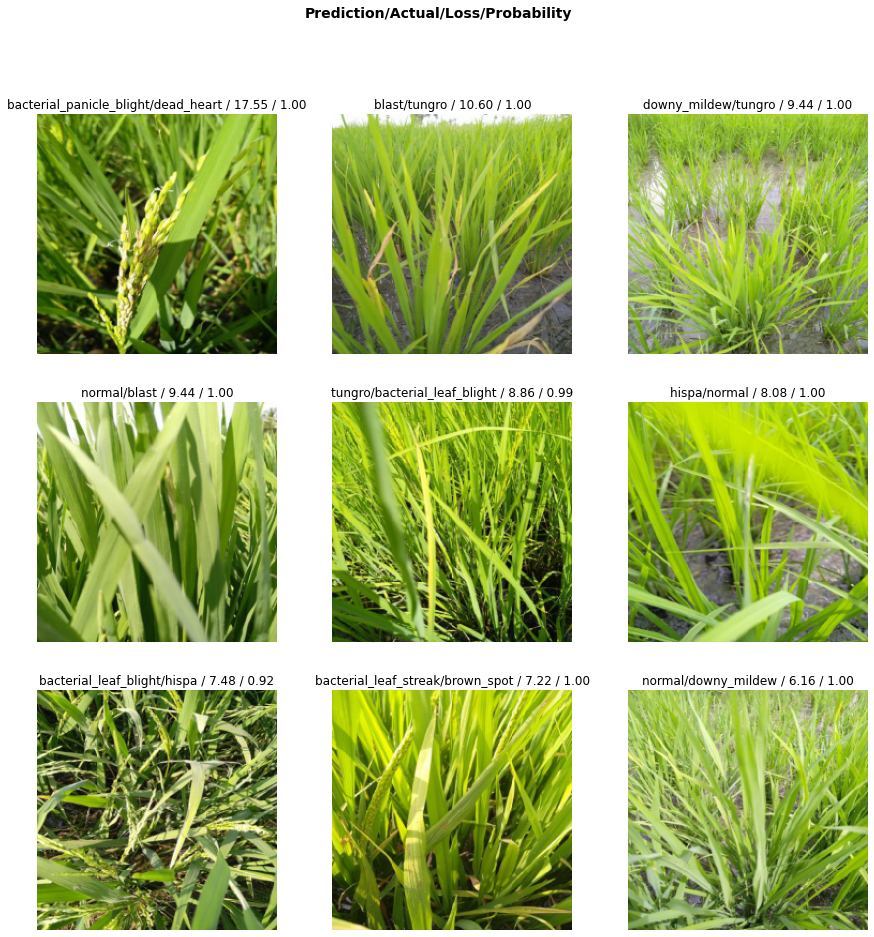

In [15]:
interp.plot_top_losses(9, figsize=(15,15))

In [16]:
test_files = get_image_files(path/'test_images').sorted(); test_files

(#3469) [Path('/home/bilal/.fastai/data/paddy/test_images/200001.jpg'),Path('/home/bilal/.fastai/data/paddy/test_images/200002.jpg'),Path('/home/bilal/.fastai/data/paddy/test_images/200003.jpg'),Path('/home/bilal/.fastai/data/paddy/test_images/200004.jpg'),Path('/home/bilal/.fastai/data/paddy/test_images/200005.jpg'),Path('/home/bilal/.fastai/data/paddy/test_images/200006.jpg'),Path('/home/bilal/.fastai/data/paddy/test_images/200007.jpg'),Path('/home/bilal/.fastai/data/paddy/test_images/200008.jpg'),Path('/home/bilal/.fastai/data/paddy/test_images/200009.jpg'),Path('/home/bilal/.fastai/data/paddy/test_images/200010.jpg')...]

In [17]:
test_dl=dls.test_dl(test_files)

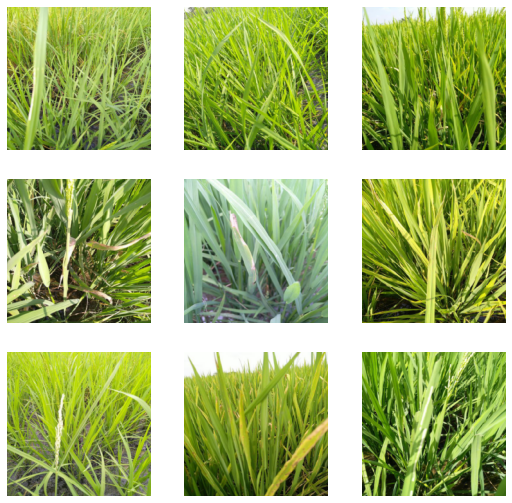

In [18]:
test_dl.show_batch()

In [20]:
# probs, _, idxs=learn.get_preds(dl=test_dl, with_decoded=True)
# idxs = pd.Series(idxs.numpy(),name="idxs")
# sample_submit = pd.read_csv(path/'sample_submission.csv')
# sample_submit.head()
# mapping = {k:v for k,v in enumerate(dls.vocab)};mapping
# result=idxs.map(mapping); result
# sample_submit['label'] = result
# sample_submit.head()
# sample_submit.to_csv('my_submit_convnext_large_in22k.csv', index=False)
# !kaggle competitions submit -f ~/mlworks/plant_disease_detection/sample_submit_convnext_large_in22k.csv -m 'convnext_large_in22k 5 epochs' paddy-disease-classification

In [30]:
sample_submit = pd.read_csv(path/'sample_submission.csv')
sample_submit.head()

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN


In [22]:
probs, targs=learn.tta(dl=dls.valid)
error_rate(probs, targs)

TensorBase(0.0202)

In [23]:
probs, targs=learn.tta(dl=test_dl)

In [24]:
probs.shape

torch.Size([3469, 10])

In [28]:
idxs=probs.argmax(1);idxs

TensorBase([7, 8, 3,  ..., 8, 1, 5])

In [29]:
idxs = pd.Series(idxs.numpy(),name="idxs")

In [32]:
mapping = dict(enumerate(dls.vocab));mapping

{0: 'bacterial_leaf_blight',
 1: 'bacterial_leaf_streak',
 2: 'bacterial_panicle_blight',
 3: 'blast',
 4: 'brown_spot',
 5: 'dead_heart',
 6: 'downy_mildew',
 7: 'hispa',
 8: 'normal',
 9: 'tungro'}

In [33]:
result=idxs.map(mapping); result
sample_submit['label'] = result
sample_submit.head()

,image_id,label
0,200001.jpg,hispa
1,200002.jpg,normal
2,200003.jpg,blast
3,200004.jpg,blast
4,200005.jpg,blast


In [34]:
sample_submit.to_csv('my_submit_convnext_large_in22k_12e_tta.csv', index=False)

In [36]:
!kaggle competitions submit -f ~/mlworks/plant_disease_detection/my_submit_convnext_large_in22k_12e_tta.csv -m 'convnext_large_in22k 12 epochs ft tta' paddy-disease-classification

100%|██████████████████████████████████████| 70.5k/70.5k [00:01<00:00, 49.2kB/s]
Successfully submitted to Paddy Doctor: Paddy Disease Classification

In [ ]:
def get_mean_std(ds):
    sum, sqrd_sum, batch_num = 0., 0., 0.
    for xb, yb in ds:
      # VAR[x] = E[X**2] - E[X]**2
      channels_sum += torch.mean(xb, dim=[0,1,2])
      channels_squared_sum += torch.mean(xb**2, dim=[0,1,2])
      num_batches += 1

    mean = channels_sum/num_batches
    std  = (channels_squared_sum/num_batches - mean**2)**0.5
    
    return ([round(mean.item(),3)]*3, [round(std.item(),3)]*3) #([round(mean,3)]*3, [round(std,3)]*3)

# paddy_stats = get_mean_std(dls.train)
# paddy_stats


In [ ]:
sum, sum_sq, num_batch = 0., 0., 0.

In [ ]:
for xb, _ in dls.train: 
    sum+= torch.mean(xb, dim=[0,2,3])
    sum_sq += torch.mean((xb ** 2), dim=[0,2,3])
    num_batch+=1

(sum, sum_sq, num_batch)

In [ ]:
mean = sum/num_batch; mean

In [ ]:
std  = (sum_sq/num_batches - mean**2)**0.5; std